In [194]:
import cv2
import time

import numpy as np

%matplotlib notebook 
import matplotlib.pyplot as plt
%matplotlib notebook

from bokeh.plotting import figure
from bokeh.io import output_notebook, show, push_notebook
from tqdm import tqdm

import IPython.display as Disp
from ipywidgets import widgets

In [231]:
def detect_image(img, template, plot_enable):
    img2 = img.copy()
    w, h = template.shape[::-1]
    
    img = img2.copy()
    method = cv2.TM_SQDIFF_NORMED

    # Apply template Matching
    res = cv2.matchTemplate(img,template,method)
    min_val, max_val, min_loc, max_loc = cv2.minMaxLoc(res)
    
    #take minimum
    top_left = min_loc
    bottom_right = (top_left[0] + w, top_left[1] + h)
    cv2.rectangle(img,top_left, bottom_right, (0,0,255), 7)

    if plot_enable:
        plt.figure()
        ax4 = plt.subplot(121),plt.imshow(res, cmap = 'gray')
        plt.title('Matching Result'), plt.xticks([]), plt.yticks([])
        ax5 = plt.subplot(122),plt.imshow(img, cmap = 'gray')
        plt.title('Detected picture'), plt.xticks([]), plt.yticks([])
        plt.suptitle(method)
        
        plt.show()
        
    center = [(top_left[0] + bottom_right[0])/2, (top_left[1] + bottom_right[1])/2]
    return center #coordinates of the center of the image.

In [232]:
def filtering(name_img, plot_enable):
    photo = cv2.imread(name_img)
    bilateral = cv2.bilateralFilter(photo,9,75,75)

    bw_photo = cv2.cvtColor(bilateral, cv2.COLOR_BGR2GRAY)

    #th2 = cv2.adaptiveThreshold(bw_photo,255,cv2.ADAPTIVE_THRESH_MEAN_C,\
    #           cv2.THRESH_BINARY,11,2)
    #th3 = cv2.adaptiveThreshold(bw_photo,255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C,\
    #        cv2.THRESH_BINARY,101,4)
    ret2,th2 = cv2.threshold(cv2.cvtColor(photo, cv2.COLOR_BGR2GRAY),0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)

    if plot_enable:
        '''fig, ax = plt.subplots(1,2, figsize=(8,4))

        ax[0][0].imshow(photo[:,:,::-1], 'gray')
        ax[0][0].set_title("Original")

        ax[0][1].imshow(th2, 'gray')
        ax[0][1].set_title("Filtered")

        plt.show()'''
        plt.figure()
        ax = plt.subplot(121),plt.imshow(photo[:,:,::-1], cmap = 'gray')
        plt.title('Original'), plt.xticks([]), plt.yticks([])
        ax1 = plt.subplot(122),plt.imshow(th2, cmap = 'gray')
        plt.title('Filtered image'), plt.xticks([]), plt.yticks([])
        
        plt.show()
        
    return th2

In [359]:
def detect_multiple(name_img, img, template, threshold, plot_enable):
    
    img_gray = img
    img_rgb = cv2.imread(name_img, cv2.IMREAD_COLOR)
    
    w, h = template.shape[::-1]

    res = cv2.matchTemplate(img_gray,template,cv2.TM_SQDIFF_NORMED)

    loc = np.where( res <= threshold)

    pt_prec = [loc[1][0], loc[0][0]]
    
    list_pt = [pt_prec] #take 1st point

    for pt in zip(*loc[::-1]):
        cv2.rectangle(img_rgb, pt, (pt[0] + w, pt[1] + h), (255,0,0), 5)
        if (abs(pt[0] - pt_prec[0]) > 1) or (abs(pt[1] - pt_prec[1]) > 1) :
            list_pt.append([pt[0], pt[1]])
        
        pt_prec = pt

    '''print(list_pt)
    list_pt = np.sort(list_pt,0)
    print(list_pt)
    
    list_final = [loc[1][0], loc[0][0]]
    
    for i in range (1,len(list_pt)):
        if (abs(list_pt[i][0] - list_pt[i-1][0]) > 1) or (abs(list_pt[i][1] - list_pt[i-1][1]) > 1) :
            list_final = np.append(list_final, list_pt[i])'''
    
    #cv2.imwrite('res.png',img_rgb)
    if plot_enable:
        plt.figure()
        ax2 = plt.subplot(121),plt.imshow(res,cmap = 'gray')
        plt.title('Matching Result'), plt.xticks([]), plt.yticks([])
        ax3 = plt.subplot(122),plt.imshow(img_rgb,cmap = 'gray')
        plt.title('Detected obstacles'), plt.xticks([]), plt.yticks([])
        
        plt.show()
        
    #list_pt contains the coordinates of the top left corners of all the objects    
    return list_pt

<IPython.core.display.Javascript object>


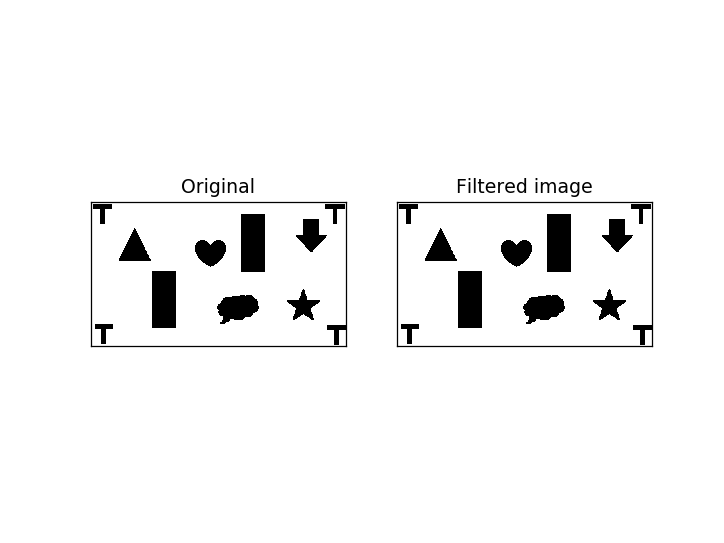

<IPython.core.display.Javascript object>


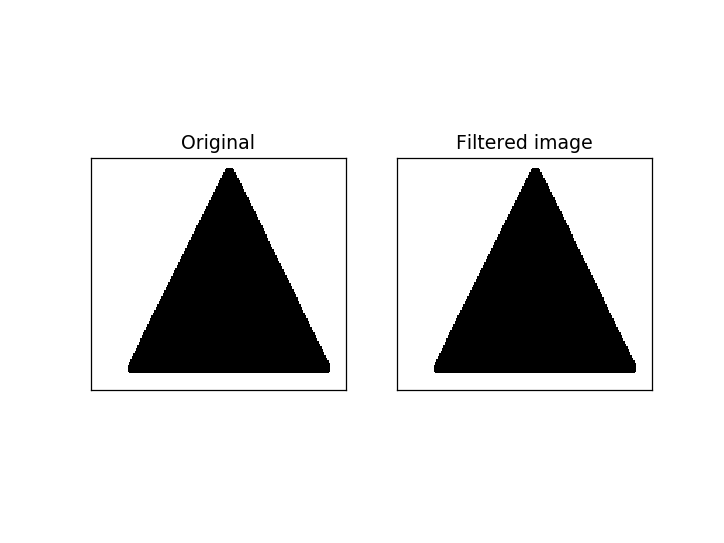

<IPython.core.display.Javascript object>


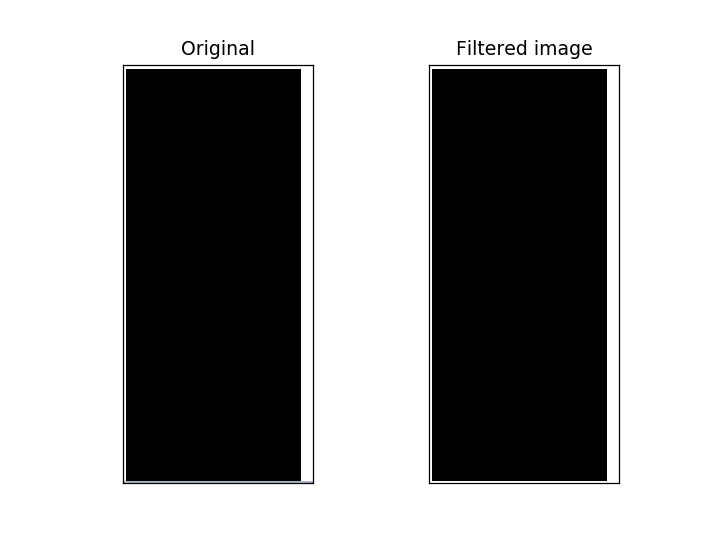

<IPython.core.display.Javascript object>


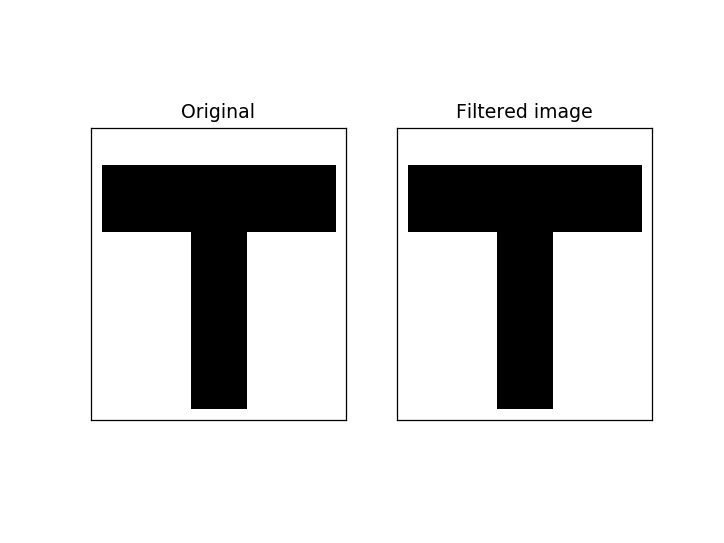

<IPython.core.display.Javascript object>


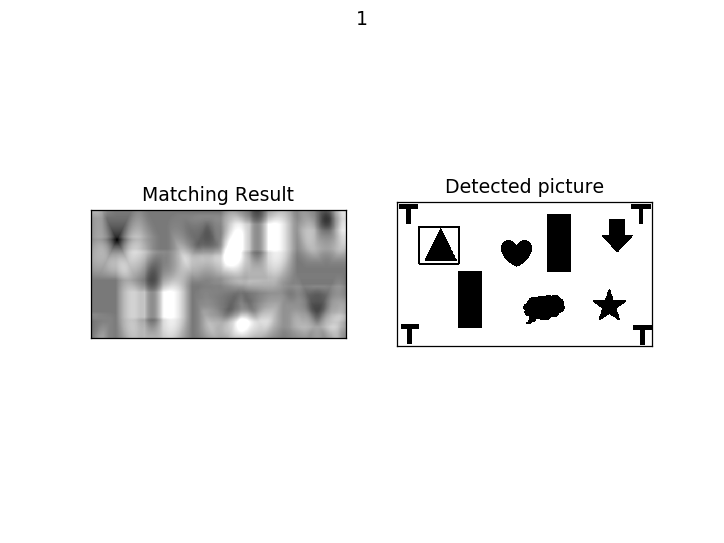

<IPython.core.display.Javascript object>


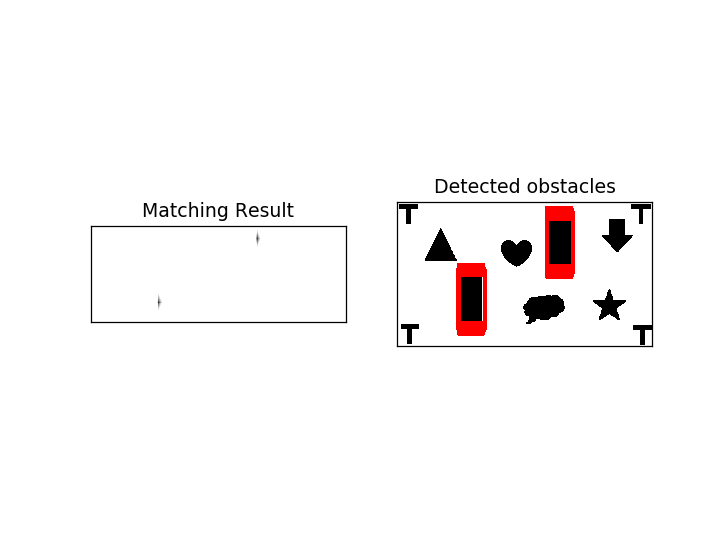

<IPython.core.display.Javascript object>


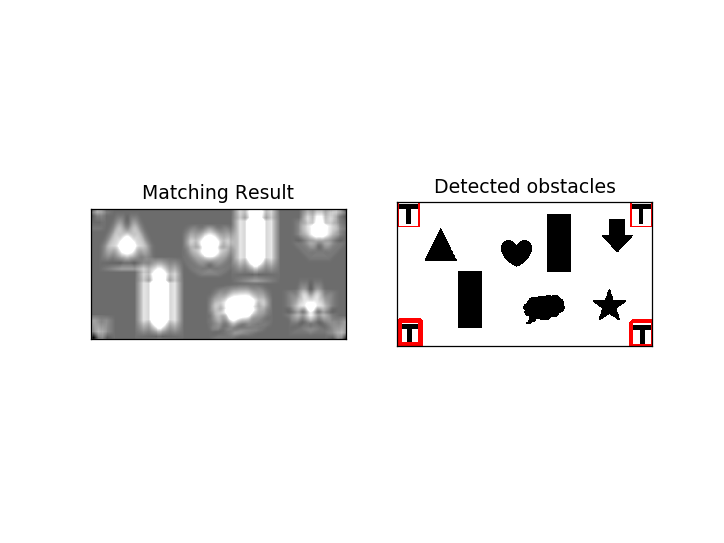

In [285]:
name_carte ='structure/cartecoin.png'
name_picture = 'oeuvres/triangle.png'
name_obstacle = 'structure/obstacle.png'
name_corner = 'structure/coin.png'
carte = cv2.imread(name_carte,0)
picture = cv2.imread(name_picture,0)
obstacle = cv2.imread(name_obstacle,0)
corner = cv2.imread(name_corner,0)
plot_enable = True


#filter images
carte_filtered = filtering(name_carte, plot_enable)
picture_filtered = filtering(name_picture, plot_enable)
obstacle_filtered = filtering(name_obstacle, plot_enable)
corner_filtered = filtering(name_corner, plot_enable)

#get coordinates of pictures and obstacles
picture_coordinates = detect_image(carte_filtered, picture_filtered, plot_enable)
list_obstacles = detect_multiple(name_carte, carte_filtered, obstacle_filtered, 0.8 , plot_enable)
list_corners = detect_multiple(name_carte, carte_filtered, corner_filtered, 0.2, plot_enable)

In [360]:
#do the G R I D
list_corners = detect_multiple(name_carte, carte_filtered, corner_filtered, 0.2, 0)
print(list_corners)


[[3, 0], [1050, 0], [4, 1], [1051, 1], [10, 526], [8, 528], [7, 529], [7, 530], [6, 531], [1057, 531], [5, 532], [1056, 532], [4, 533], [1055, 533], [3, 534], [1054, 534], [4, 535], [1054, 535], [5, 536], [1052, 536], [6, 537], [1051, 537], [7, 538], [1050, 538], [8, 539], [1049, 539]]


In [386]:

a = sorted(list_corners , key=lambda k: [k[1], k[0]])

print(a)


[[3, 0], [1050, 0], [4, 1], [1051, 1], [10, 526], [8, 528], [7, 529], [7, 530], [6, 531], [1057, 531], [5, 532], [1056, 532], [4, 533], [1055, 533], [3, 534], [1054, 534], [4, 535], [1054, 535], [5, 536], [1052, 536], [6, 537], [1051, 537], [7, 538], [1050, 538], [8, 539], [1049, 539]]


In [376]:
my_list = [[1,2],[0,2],[2,1],[1,1],[2,2],[2,0],[0,1],[1,0],[0,0]]
sorted(my_list , key=lambda k: [k[1], k[0]])
[[0, 0], [1, 0], [2, 0], [0, 1], [1, 1], [2, 1], [0, 2], [1, 2], [2, 2]]

[[0, 0], [1, 0], [2, 0], [0, 1], [1, 1], [2, 1], [0, 2], [1, 2], [2, 2]]